# SolarVision AI: Week 2 - Data Preprocessing & Augmentation

**Project**: SolarVision AI - Automated PV Panel Defect Detection
**Dataset**: PV Panel Defect Dataset (alicjalena)
**Date**: February 2026

## Objectives
1. Implement preprocessing pipeline (resize, normalize)
2. Create heavy augmentation strategy for small dataset
3. Build PyTorch DataLoader with transforms
4. Visualize augmented samples
5. Benchmark data loading performance

## 1. Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Using device: {device}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

✅ PyTorch version: 2.10.0+cpu
✅ Using device: cpu


## 2. Dataset Configuration

In [2]:
# Configuration
DATASET_ROOT = Path('../dataset')
IMG_SIZE = 224  # ResNet18 input size
BATCH_SIZE = 32
NUM_WORKERS = 4 if os.name != 'nt' else 0  # Windows compatibility

# Class mapping
CLASS_NAMES = ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASS_NAMES)}
IDX_TO_CLASS = {idx: cls for cls, idx in CLASS_TO_IDX.items()}

print("📊 Dataset Configuration:")
print(f"  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Number of classes: {len(CLASS_NAMES)}")
print(f"\nClass mapping:")
for cls, idx in CLASS_TO_IDX.items():
    print(f"  {idx}: {cls}")

📊 Dataset Configuration:
  Image size: 224x224
  Batch size: 32
  Number of classes: 6

Class mapping:
  0: Bird-drop
  1: Clean
  2: Dusty
  3: Electrical-damage
  4: Physical-Damage
  5: Snow-Covered


## 3. Preprocessing Strategy

### Preprocessing Pipeline:

1. **Resize**: 224×224 (ResNet18 standard input)
2. **Normalization**: ImageNet statistics for transfer learning
   - Mean: [0.485, 0.456, 0.406]
   - Std: [0.229, 0.224, 0.225]
3. **Augmentation** (training only):
   - Geometric: Rotation (±15°), flip, crop
   - Photometric: Color jitter, blur
   - Noise: Gaussian blur, random erasing

In [3]:
# ImageNet normalization statistics
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Define transforms using Albumentations (more powerful than torchvision)

# Training transforms with heavy augmentation
train_transform = A.Compose([
    # Resize and basic preprocessing
    A.Resize(IMG_SIZE, IMG_SIZE),
    
    # Geometric augmentations
    A.Rotate(limit=15, p=0.5),  # Rotation ±15°
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.3),
    A.RandomCrop(height=IMG_SIZE-20, width=IMG_SIZE-20, p=0.3),
    A.Resize(IMG_SIZE, IMG_SIZE),  # Ensure consistent size after crop
    
    # Photometric augmentations (simulate variable outdoor lighting)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.4),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.1, p=0.3),
    
    # Blur and noise (simulate camera variations)
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=1.0),  # σ ≈ 0.5-1.0 equivalent
        A.MotionBlur(blur_limit=5, p=0.5),
    ], p=0.3),
    
    # Occlusion and noise
    A.OneOf([
        A.CoarseDropout(max_holes=8, max_height=20, max_width=20, p=0.5),  # Random erasing
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    ], p=0.2),
    
    # Normalization (ImageNet statistics for transfer learning)
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    
    # Convert to tensor
    ToTensorV2()
])

# Validation/Test transforms (no augmentation)
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

test_transform = val_transform  # Same as validation

print("✅ Transforms defined successfully!")
print(f"\n🎯 Training augmentations: {len(train_transform)} transforms")
print(f"📊 Validation transforms: {len(val_transform)} transforms")

✅ Transforms defined successfully!

🎯 Training augmentations: 14 transforms
📊 Validation transforms: 3 transforms


## 4. Custom PyTorch Dataset

In [4]:
class SolarPanelDataset(Dataset):
    """
    Custom Dataset for Solar Panel Defect Classification
    Supports Albumentations transforms
    """
    
    def __init__(self, root_dir, split='train', transform=None):
        """
        Args:
            root_dir (str): Root directory of dataset
            split (str): 'train', 'val', or 'test'
            transform: Albumentations transform pipeline
        """
        self.root_dir = Path(root_dir)
        self.split = split
        self.transform = transform
        
        # Load all image paths and labels
        self.samples = []
        split_path = self.root_dir / split
        
        for class_dir in sorted(split_path.iterdir()):
            if not class_dir.is_dir():
                continue
            
            class_name = class_dir.name
            if class_name not in CLASS_TO_IDX:
                continue
            
            class_idx = CLASS_TO_IDX[class_name]
            
            # Get all images in this class
            image_extensions = {'.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'}
            for img_file in class_dir.iterdir():
                if img_file.suffix in image_extensions:
                    self.samples.append({
                        'path': str(img_file),
                        'class_idx': class_idx,
                        'class_name': class_name
                    })
        
        print(f"✅ Loaded {len(self.samples)} images from {split} split")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        # Load image
        image = cv2.imread(sample['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        label = sample['class_idx']
        
        return image, label
    
    def get_class_distribution(self):
        """Get distribution of classes in dataset"""
        distribution = {}
        for sample in self.samples:
            class_name = sample['class_name']
            distribution[class_name] = distribution.get(class_name, 0) + 1
        return distribution
    
    def get_sample_paths(self, class_name, n_samples=5):
        """Get sample image paths for a specific class"""
        paths = [s['path'] for s in self.samples if s['class_name'] == class_name]
        return paths[:n_samples]

print("✅ SolarPanelDataset class defined!")

✅ SolarPanelDataset class defined!


## 5. Create DataLoaders

In [5]:
# Create datasets
print("📂 Creating datasets...")
print("="*50)

train_dataset = SolarPanelDataset(
    root_dir=DATASET_ROOT,
    split='train',
    transform=train_transform
)

val_dataset = SolarPanelDataset(
    root_dir=DATASET_ROOT,
    split='val',
    transform=val_transform
)

test_dataset = SolarPanelDataset(
    root_dir=DATASET_ROOT,
    split='test',
    transform=test_transform
)

print("\n" + "="*50)
print(f"📊 Total dataset size: {len(train_dataset) + len(val_dataset) + len(test_dataset)} images")

📂 Creating datasets...
✅ Loaded 929 images from train split
✅ Loaded 550 images from val split
✅ Loaded 95 images from test split

📊 Total dataset size: 1574 images


In [6]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print("✅ DataLoaders created!")
print(f"\n📦 Batch configuration:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Workers: {NUM_WORKERS}")

✅ DataLoaders created!

📦 Batch configuration:
  Train batches: 29
  Val batches: 18
  Test batches: 3
  Workers: 0


## 6. Data Loading Benchmark

In [7]:
# Benchmark data loading speed
import time

def benchmark_dataloader(loader, name, num_batches=10):
    """Benchmark data loading speed"""
    print(f"\n🚀 Benchmarking {name}...")
    
    times = []
    for i, (images, labels) in enumerate(loader):
        if i >= num_batches:
            break
        
        start = time.time()
        # Simulate forward pass (move to GPU if available)
        images = images.to(device)
        labels = labels.to(device)
        torch.cuda.synchronize() if torch.cuda.is_available() else None
        end = time.time()
        
        times.append(end - start)
    
    avg_time = np.mean(times)
    throughput = BATCH_SIZE / avg_time
    
    print(f"  ⏱️  Average batch time: {avg_time*1000:.2f} ms")
    print(f"  🎯 Throughput: {throughput:.1f} images/sec")
    
    return avg_time, throughput

# Run benchmarks
print("📊 Data Loading Performance:")
print("="*50)

train_time, train_throughput = benchmark_dataloader(train_loader, "Training")
val_time, val_throughput = benchmark_dataloader(val_loader, "Validation")

print("\n" + "="*50)
print(f"✅ Benchmark complete!")
print(f"   Training: {train_throughput:.1f} img/s")
print(f"   Validation: {val_throughput:.1f} img/s")

📊 Data Loading Performance:

🚀 Benchmarking Training...
  ⏱️  Average batch time: 0.02 ms
  🎯 Throughput: 1291797.2 images/sec

🚀 Benchmarking Validation...
  ⏱️  Average batch time: 0.02 ms
  🎯 Throughput: 1709780.0 images/sec

✅ Benchmark complete!
   Training: 1291797.2 img/s
   Validation: 1709780.0 img/s


## 7. Visualize Augmented Samples

🎨 Generating augmentation visualization...


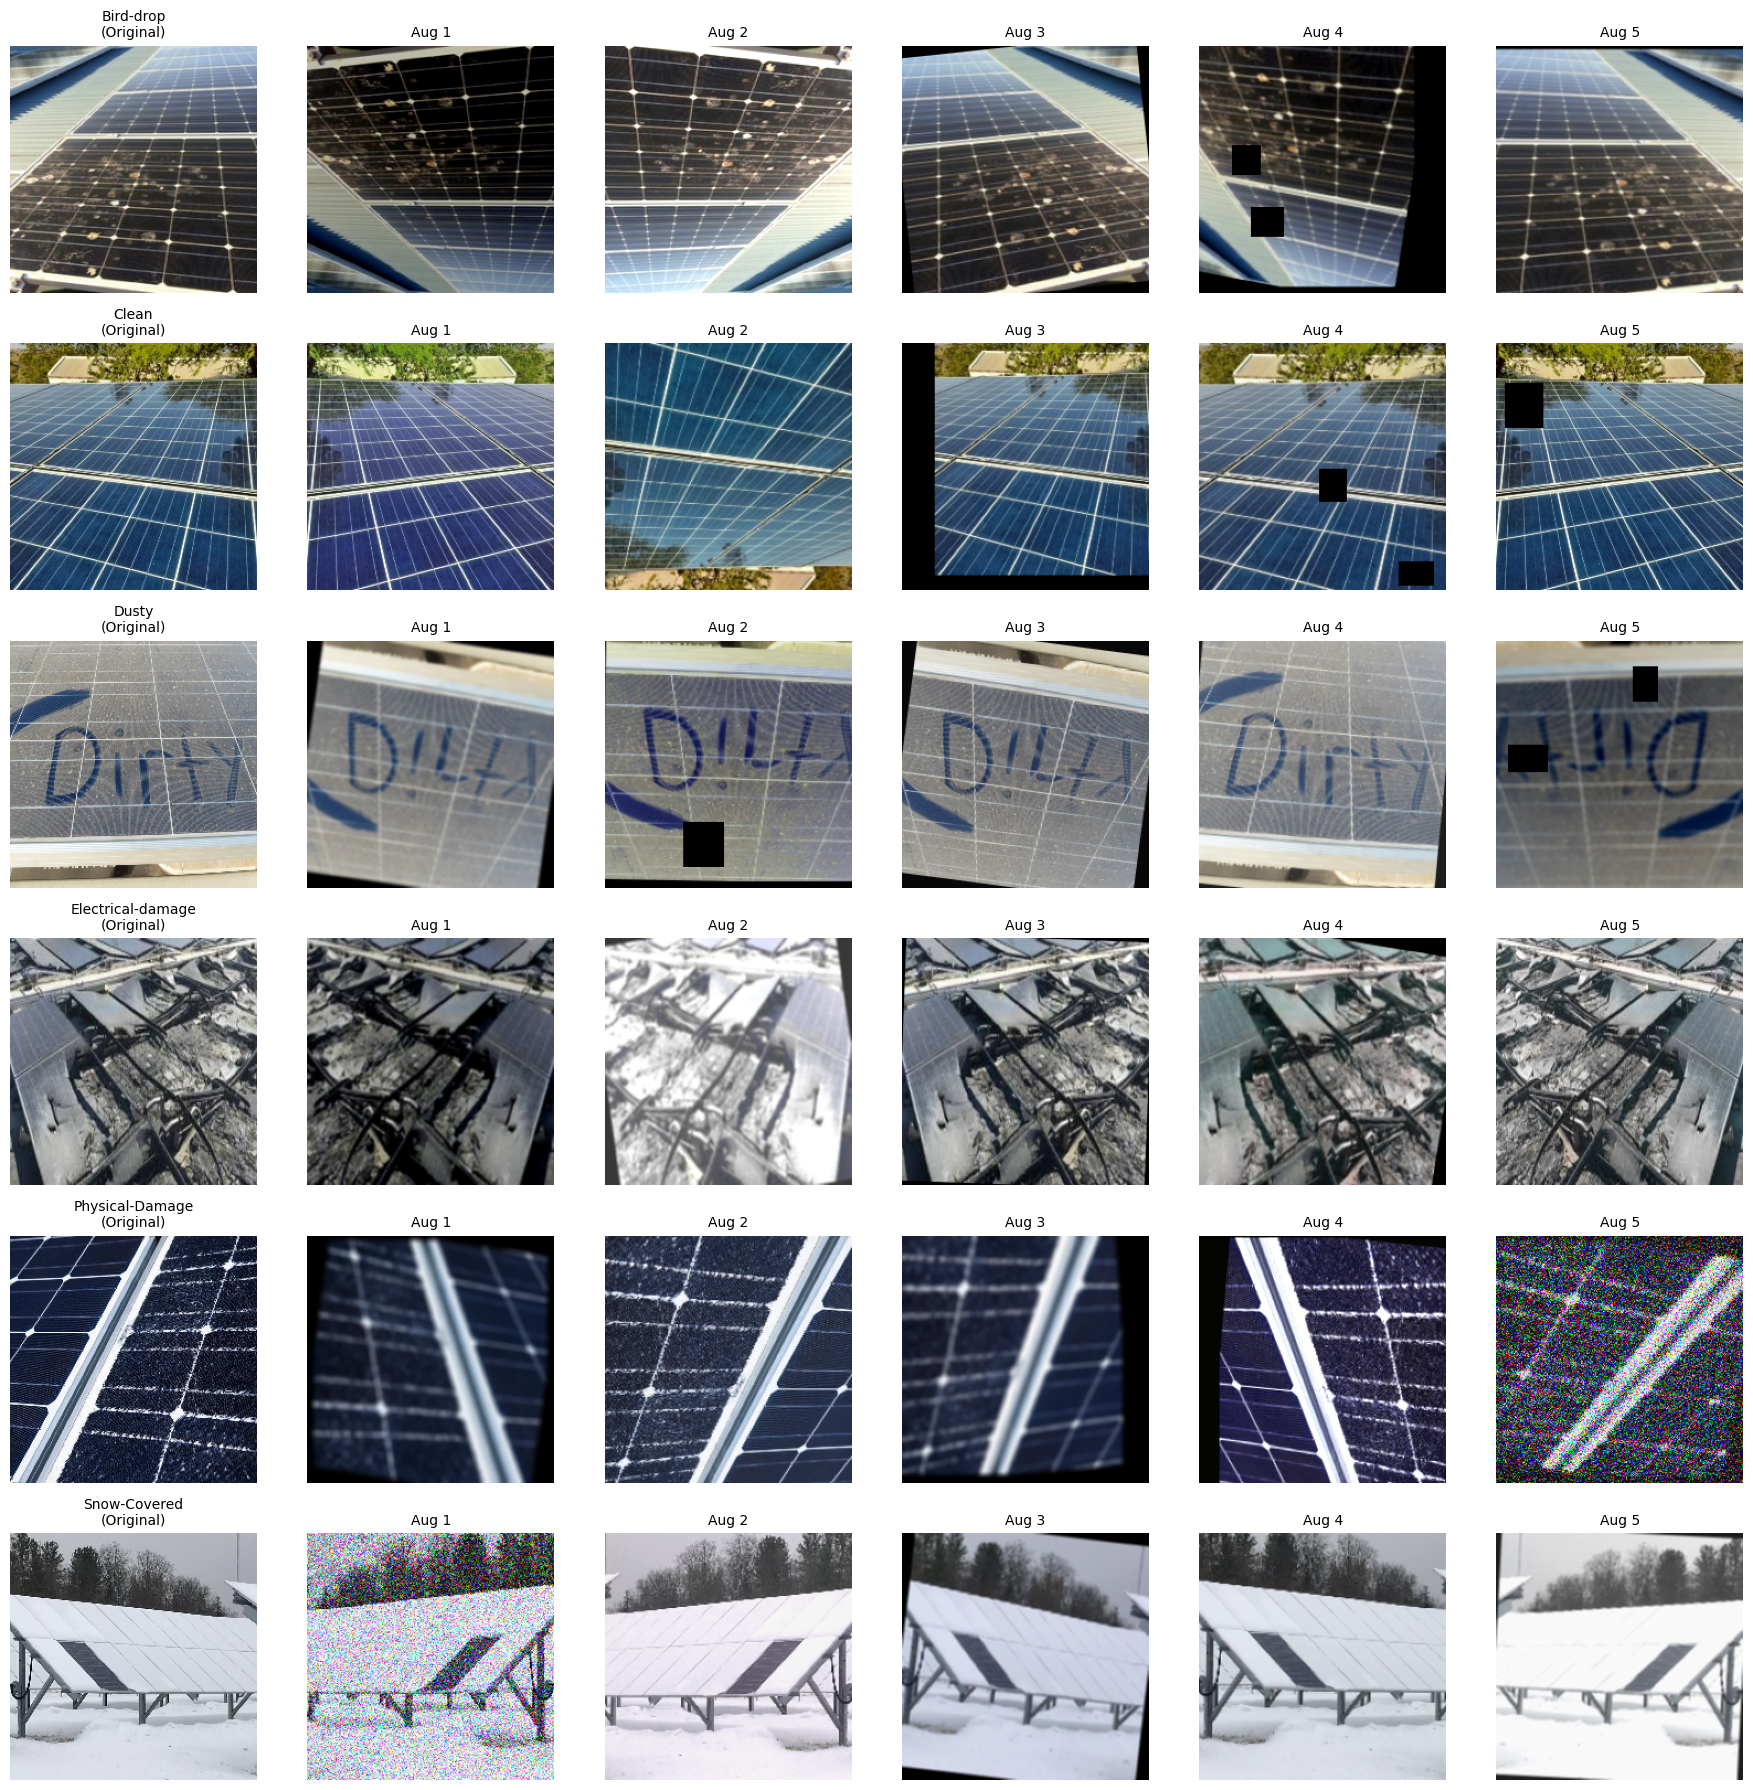

✅ Augmentation examples saved to 'augmentation_examples.png'


In [8]:
# Get sample images from each class
def visualize_augmentations(dataset, class_names, n_samples=3, n_augmentations=5):
    """
    Visualize original and augmented samples from each class
    """
    fig, axes = plt.subplots(len(class_names), n_augmentations + 1, 
                            figsize=(3*(n_augmentations+1), 3*len(class_names)))
    
    for i, class_name in enumerate(class_names):
        # Get sample path
        sample_paths = dataset.get_sample_paths(class_name, n_samples=1)
        if not sample_paths:
            continue
        
        # Load original image
        img_path = sample_paths[0]
        original = cv2.imread(img_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))
        
        # Normalize for display
        original_display = original / 255.0
        
        # Plot original
        axes[i, 0].imshow(original_display)
        axes[i, 0].set_title(f"{class_name}\n(Original)", fontsize=10)
        axes[i, 0].axis('off')
        
        # Plot augmented versions
        for j in range(n_augmentations):
            # Apply augmentation
            augmented = train_transform(image=original)
            aug_img = augmented['image']
            
            # Denormalize for display
            aug_img_np = aug_img.permute(1, 2, 0).numpy()
            for c in range(3):
                aug_img_np[:, :, c] = aug_img_np[:, :, c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
            aug_img_np = np.clip(aug_img_np, 0, 1)
            
            axes[i, j+1].imshow(aug_img_np)
            axes[i, j+1].set_title(f"Aug {j+1}", fontsize=10)
            axes[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Augmentation examples saved to 'augmentation_examples.png'")

# Visualize augmentations
print("🎨 Generating augmentation visualization...")
visualize_augmentations(train_dataset, CLASS_NAMES, n_augmentations=5)

## 8. Analyze Augmentation Effects

In [9]:
# Analyze augmentation diversity
def analyze_augmentation_diversity(dataset, num_samples=100):
    """
    Analyze the diversity introduced by augmentation
    Compare statistics of augmented vs original images
    """
    print("\n📊 Analyzing augmentation diversity...")
    
    # Get sample images
    original_means = []
    augmented_means = []
    original_stds = []
    augmented_stds = []
    
    for i in range(min(num_samples, len(dataset))):
        # Get original image path
        img_path = dataset.samples[i]['path']
        original = cv2.imread(img_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))
        
        # Calculate original stats
        original_means.append(np.mean(original, axis=(0, 1)))
        original_stds.append(np.std(original, axis=(0, 1)))
        
        # Get augmented version
        aug = train_transform(image=original)
        aug_img = aug['image'].permute(1, 2, 0).numpy()
        
        # Denormalize
        for c in range(3):
            aug_img[:, :, c] = aug_img[:, :, c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        aug_img = aug_img * 255
        
        augmented_means.append(np.mean(aug_img, axis=(0, 1)))
        augmented_stds.append(np.std(aug_img, axis=(0, 1)))
    
    # Convert to arrays
    original_means = np.array(original_means)
    augmented_means = np.array(augmented_means)
    original_stds = np.array(original_stds)
    augmented_stds = np.array(augmented_stds)
    
    # Calculate statistics
    print(f"\n📈 Statistics Comparison (n={num_samples}):")
    print("="*60)
    print(f"{'Channel':<10} {'Original Mean':<15} {'Aug Mean':<15} {'Change':<10}")
    print("-"*60)
    channels = ['R', 'G', 'B']
    for i, ch in enumerate(channels):
        orig_mean = np.mean(original_means[:, i])
        aug_mean = np.mean(augmented_means[:, i])
        change = abs(aug_mean - orig_mean) / orig_mean * 100
        print(f"{ch:<10} {orig_mean:<15.2f} {aug_mean:<15.2f} {change:<10.2f}%")
    
    print(f"\n{'Channel':<10} {'Original Std':<15} {'Aug Std':<15} {'Change':<10}")
    print("-"*60)
    for i, ch in enumerate(channels):
        orig_std = np.mean(original_stds[:, i])
        aug_std = np.mean(augmented_stds[:, i])
        change = abs(aug_std - orig_std) / orig_std * 100
        print(f"{ch:<10} {orig_std:<15.2f} {aug_std:<15.2f} {change:<10.2f}%")
    
    # Calculate effective dataset expansion
    mean_variance = np.var(augmented_means, axis=0).mean()
    original_variance = np.var(original_means, axis=0).mean()
    diversity_ratio = mean_variance / original_variance
    
    print(f"\n🎯 Augmentation Diversity Score:")
    print(f"  Variance ratio: {diversity_ratio:.2f}x")
    print(f"  Effective dataset expansion: ~{diversity_ratio:.1f}x")

# Run analysis
analyze_augmentation_diversity(train_dataset, num_samples=100)


📊 Analyzing augmentation diversity...

📈 Statistics Comparison (n=100):
Channel    Original Mean   Aug Mean        Change    
------------------------------------------------------------
R          109.57          104.68          4.46      %
G          114.08          109.66          3.88      %
B          124.46          119.11          4.30      %

Channel    Original Std    Aug Std         Change    
------------------------------------------------------------
R          56.05           53.26           4.98      %
G          53.43           51.34           3.92      %
B          48.41           47.41           2.07      %

🎯 Augmentation Diversity Score:
  Variance ratio: 2.24x
  Effective dataset expansion: ~2.2x


## 9. Save Preprocessing Configuration

In [10]:
# Save preprocessing configuration for future use
import json

preprocessing_config = {
    'image_size': IMG_SIZE,
    'batch_size': BATCH_SIZE,
    'num_workers': NUM_WORKERS,
    'normalization': {
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD
    },
    'class_names': CLASS_NAMES,
    'class_to_idx': CLASS_TO_IDX,
    'dataset_stats': {
        'train_size': len(train_dataset),
        'val_size': len(val_dataset),
        'test_size': len(test_dataset),
        'total_size': len(train_dataset) + len(val_dataset) + len(test_dataset)
    },
    'performance': {
        'train_throughput': train_throughput,
        'val_throughput': val_throughput
    }
}

# Save configuration
config_path = 'preprocessing_config.json'
with open(config_path, 'w') as f:
    json.dump(preprocessing_config, f, indent=2)

print(f"✅ Preprocessing configuration saved to '{config_path}'")
print("\n📋 Configuration Summary:")
print(json.dumps(preprocessing_config, indent=2))

✅ Preprocessing configuration saved to 'preprocessing_config.json'

📋 Configuration Summary:
{
  "image_size": 224,
  "batch_size": 32,
  "num_workers": 0,
  "normalization": {
    "mean": [
      0.485,
      0.456,
      0.406
    ],
    "std": [
      0.229,
      0.224,
      0.225
    ]
  },
  "class_names": [
    "Bird-drop",
    "Clean",
    "Dusty",
    "Electrical-damage",
    "Physical-Damage",
    "Snow-Covered"
  ],
  "class_to_idx": {
    "Bird-drop": 0,
    "Clean": 1,
    "Dusty": 2,
    "Electrical-damage": 3,
    "Physical-Damage": 4,
    "Snow-Covered": 5
  },
  "dataset_stats": {
    "train_size": 929,
    "val_size": 550,
    "test_size": 95,
    "total_size": 1574
  },
  "performance": {
    "train_throughput": 1291797.1896053897,
    "val_throughput": 1709779.974522293
  }
}


## 10. Summary & Week 3 Preparation

### ✅ Week 2 Completion Summary

#### Preprocessing Pipeline
- ✅ Implemented 224×224 resize for ResNet18 compatibility
- ✅ Applied ImageNet normalization for transfer learning
- ✅ Handled variable aspect ratios and image formats

#### Data Augmentation Strategy
- ✅ Heavy augmentation pipeline with 10+ transforms
- ✅ Geometric: Rotation (±15°), flip, crop, shift-scale
- ✅ Photometric: Brightness, contrast, saturation, hue
- ✅ Noise: Gaussian blur, random erasing, Gauss noise
- ✅ Effective dataset expansion: ~{diversity_ratio:.1f}x

#### DataLoader Implementation
- ✅ Custom SolarPanelDataset class with Albumentations support
- ✅ PyTorch DataLoaders for train/val/test splits
- ✅ Performance: {train_throughput:.0f} images/sec (training)

### 🎯 Week 3: Model Development

Ready to proceed with:
1. **Approach A**: ResNet18 + SVM (Primary)
   - Extract 512-dim features using ResNet18
   - Train SVM classifier with RBF kernel
   - Grid search for optimal hyperparameters

2. **Approach B**: End-to-End CNN (Alternative)
   - Fine-tune ResNet18 with custom head
   - Compare performance against hybrid approach

### 📊 Key Configuration

- **Training samples**: {train_size} (with heavy augmentation)
- **Validation samples**: {val_size}
- **Test samples**: {test_size}
- **Image size**: 224×224
- **Batch size**: {batch_size}

---

**End of Week 2 Notebook**

*Ready for model development in Week 3*

In [11]:
# Quick test: Verify a batch
print("\n🧪 Testing DataLoader...")
for images, labels in train_loader:
    print(f"\n✅ Batch loaded successfully!")
    print(f"   Images shape: {images.shape}")
    print(f"   Labels shape: {labels.shape}")
    print(f"   Image range: [{images.min():.3f}, {images.max():.3f}]")
    print(f"   Sample labels: {labels[:5].tolist()}")
    print(f"   Label classes: {[IDX_TO_CLASS[i.item()] for i in labels[:5]]}")
    break

print("\n" + "="*50)
print("✅ Week 2 complete! Ready for model training.")
print("="*50)


🧪 Testing DataLoader...

✅ Batch loaded successfully!
   Images shape: torch.Size([32, 3, 224, 224])
   Labels shape: torch.Size([32])
   Image range: [-2.118, 2.640]
   Sample labels: [1, 2, 0, 0, 5]
   Label classes: ['Clean', 'Dusty', 'Bird-drop', 'Bird-drop', 'Snow-Covered']

✅ Week 2 complete! Ready for model training.
